In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import pandas as pd

# Data Preprocessing

In [38]:
df = pd.read_csv('data/mails.csv')
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [41]:
# Remove empty rows with no mail text, also drop NaN entries and drop \n characters
df_cleaned = df[df['Body'] != 'empty'].iloc[:, 1:]
df_cleaned = df_cleaned.dropna(subset=['Body'])
df_cleaned['Body'] = df_cleaned['Body'].replace('\n', ' ', regex=True)
df_cleaned.head()

,Body,Label
0,Save up to 70% on Life Insurance. Why Spend M...,1
1,1) Fight The Risk of Cancer! http://www.adclic...,1
2,1) Fight The Risk of Cancer! http://www.adclic...,1
3,##############################################...,1
4,I thought you might like these: 1) Slim Down -...,1


In [42]:
# Mail text
X = df_cleaned['Body']

# Labels
y = df_cleaned['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
X.head()

0     Save up to 70% on Life Insurance. Why Spend M...
1    1) Fight The Risk of Cancer! http://www.adclic...
2    1) Fight The Risk of Cancer! http://www.adclic...
3    ##############################################...
4    I thought you might like these: 1) Slim Down -...
Name: Body, dtype: object

## LinearSVC

In [45]:
pipeline = make_pipeline( TfidfVectorizer(), LinearSVC() )

parameters = {
    'tfidfvectorizer__max_features': [None, 2000, 3000, 5000, 7000, 9000, 10000],
    'tfidfvectorizer__max_df': [0.7, 0.8, 0.9, 0.95, 1], 
    'linearsvc__C': [0.01, 0.1, 1, 10],
}

grid_search_linearSVC = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search_linearSVC.fit(X_train, y_train)

best_model_svc = grid_search_linearSVC.best_estimator_


Fitting 5 folds for each of 140 candidates, totalling 700 fits


In [46]:
print("Best parameters:", grid_search_linearSVC.best_params_)
print("Best cv accuracy score:", grid_search_linearSVC.best_score_)

Best parameters: {'linearsvc__C': 10, 'tfidfvectorizer__max_df': 0.9, 'tfidfvectorizer__max_features': None}
Best cv accuracy score: 0.9895673592933202


LinearSVC accuracy: 0.9873073436083409
Specificity: 0.99609375
Sensitivity: 0.9671641791044776


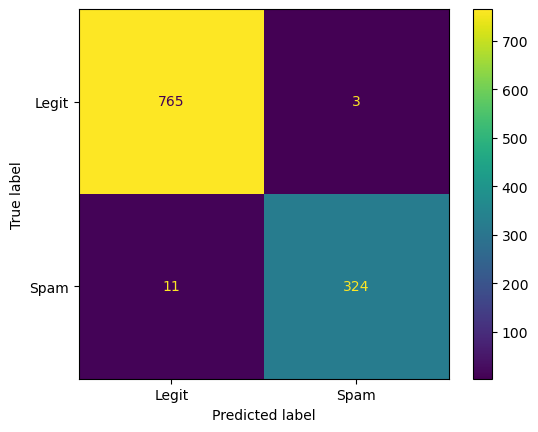

In [47]:
print(f"LinearSVC accuracy: {best_model_svc.score(X_test, y_test)}")
predictions = best_model_svc.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_model_svc.classes_)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
print(f"Specificity: {tn / (tn + fp)}")
print(f"Sensitivity: {tp / (tp + fn)}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Spam"])
disp.plot()

Specificity is higher, which is preferable if we don't want legit mails to be classified as spam!

## MultinomialNB

In [48]:
pipeline = make_pipeline( TfidfVectorizer(), MultinomialNB() )

parameters = {
    'tfidfvectorizer__max_features': [None, 2000, 3000, 5000, 7000, 9000, 10000],
    'tfidfvectorizer__max_df': [0.7, 0.8, 0.9, 0.95, 1], 
    'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 5, 10],
}

grid_search_naive = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search_naive.fit(X_train, y_train)

best_model_nb = grid_search_naive.best_estimator_

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


In [49]:
print("Best parameters:", grid_search_naive.best_params_)
print("Best cv accuracy score:", grid_search_naive.best_score_)

Best parameters: {'multinomialnb__alpha': 0.01, 'tfidfvectorizer__max_df': 0.8, 'tfidfvectorizer__max_features': None}
Best cv accuracy score: 0.9861647118173792


MultinomialNB accuracy: 0.986400725294651
Specificity: 1.0
Sensitivity: 0.9552238805970149


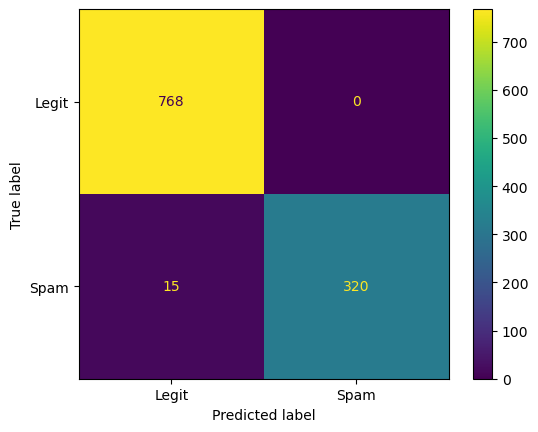

In [66]:
print(f"MultinomialNB accuracy: {best_model_nb.score(X_test, y_test)}")
predictions = best_model_nb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_model_nb.classes_)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
print(f"Specificity: {tn / (tn + fp)}")
print(f"Sensitivity: {tp / (tp + fn)}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Spam"])
disp.plot()


Even better specificity than the LinearSVC clf, but worse sensitivity!

## Random Forest Classifier

In [51]:
pipeline = make_pipeline( TfidfVectorizer(), RandomForestClassifier() )

parameters = {
    'tfidfvectorizer__max_features': [None, 5000, 10000],
    'tfidfvectorizer__max_df': [0.75, 0.9, 1.0], 
    'randomforestclassifier__n_estimators': [100, 300, 450],
    'randomforestclassifier__max_depth': [None, 60, 90, 120],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
}


grid_search_forest = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search_forest.fit(X_test, y_test)

best_model_rf = grid_search_forest.best_estimator_

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


In [52]:
print("Best parameters:", grid_search_forest.best_params_)
print("Best cv accuracy score:", grid_search_forest.best_score_)

Best parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 120, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 300, 'tfidfvectorizer__max_df': 0.75, 'tfidfvectorizer__max_features': 5000}
Best cv accuracy score: 0.971007815713698


Random Forest accuracy: 1.0
Specificity: 1.0
Sensitivity: 1.0


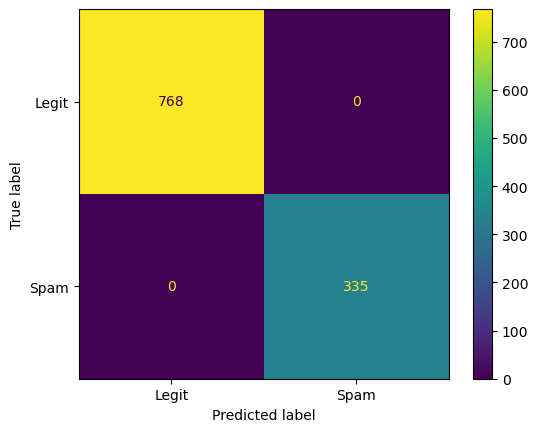

In [53]:
print(f"Random Forest accuracy: {best_model_rf.score(X_test, y_test)}")
predictions = best_model_rf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=best_model_rf.classes_)
tn = cm[0,0]
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
print(f"Specificity: {tn / (tn + fp)}")
print(f"Sensitivity: {tp / (tp + fn)}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit", "Spam"])
disp.plot()

Best performance of all three classifiers!